In [1]:
import jax
import jax.numpy as np
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import numpy,pickle
from jax.tree_util import tree_map, tree_flatten
from jax.flatten_util import ravel_pytree

from jax import jit,vmap,lax
import pandas as pd
import blackjax


import sys,os,importlib,pdb
sys.path.append('/mnt/home/szheng/projects/util_code')
import gm

import scipy
from scipy.signal import find_peaks
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
from importlib import reload

import copy

%matplotlib inline
import gm_glm_bayesian as glm
import gm_glm_bayesian_helper as glmh
import math_functions as mf
import plot_mcmc as pmc
reload(pmc)

import gm_cv as gc
import glm_cv as glmc

from scipy.ndimage import gaussian_filter1d

In [2]:
def mask_fields(pars,nfields_mask,to_mask=['w','sigma','mu']):
    pars_ = {}
    nfields_mask = nfields_mask.astype(bool) # make sure it's bool!

    for k,val in pars.items():
        domask = False
        for tm in to_mask:
            if tm in k:
                domask=True
        if domask:    

            pars_[k] = pars[k][:,nfields_mask]
        else:
            pars_[k] = pars[k]
    return pars_
            

In [3]:
sess_name="e15_13f1_220117"
py_data_dir = "/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data"
fr_ = pickle.load(open(os.path.join(py_data_dir,'fr.p'),'rb'))
pos_bins = fr_['pos_bins']['lin']
bin_to_lin=numpy.concatenate([pos_bins[:-1,None],pos_bins[1:,None]],axis=1).mean(axis=1)

fr = fr_['df']['pyr']
fr_map_ = pickle.load(open(os.path.join(py_data_dir,'fr_map.p'),'rb'))['fr_map_trial']
fr_map_avg=pickle.load(open(os.path.join(py_data_dir,'fr_map.p'),'rb'))['fr_map']
cell_cols = fr_['cell_cols']

In [4]:
unit_int = 31
unit_str = f'unit_{unit_int}'

unit_ind_in_pyr = [i for i in range(len(cell_cols['pyr']))  if unit_str == cell_cols['pyr'][i]][0]

trial_ind_dict = dict(fr.groupby('visitedArm')['trial'].unique())
fr_map_one_unit_both_trials_dict = {k:val[unit_ind_in_pyr] for k,val in fr_map_.items()}
pars=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None)

pars_rand=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None,random_init=True)

fr_filtered=fr.query("(speed>=5.)")
fr_ = fr_filtered

trial_type_by_trial=fr_.groupby(['trial','visitedArm']).mean().index.get_level_values(1).astype(int)

# fr_=fr
regressors=glm.get_regressors(fr_)
target_spk_allneurons = np.array(fr_[cell_cols['pyr']].values)
target_spk_oneneuron = target_spk_allneurons[:,0]


2022-08-24 21:52:11.233566: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [5]:
# need to select one trial correctly
reload(glm)
ch=0
# regressors_one_trial,target_spk_one_trial_one_neuron = glm.subselect_regressors(regressors, target_spk_allneurons[:,0], trial_type=ch)
regressors_one_trial,target_spk_one_trial = glm.subselect_regressors(regressors, target_spk_allneurons, trial_type=ch)



In [6]:
key = jax.random.PRNGKey(0)
# fit_kwargs=dict(reg_type = 'gaussian_logprior_laplacian',lr=0.05,loss_type='poisson',niters=4000,nfields_max=2)
fit_kwargs=dict(lr=0.05,niters=4000)
# target_all_neurons = target_spk_one_trial_one_neuron#target_spk_oneneuron #target_spk_one_trial
regressors_ = regressors_one_trial#regressors # regressors_one_trial
regressors_['ntrials'] = len(numpy.unique(regressors_['trial_inds_int']))
reg_pars = gm.get_reg_pars({'g_w':1000.,'g_b':1000000.,'g_sigma_thresh':100000.,'sigma_thresh':3,'g_sigma_shrinkage':0.,'nfields_mask':np.array([1,1,1,1])})
# pars_learned, train_loss_with_reg, test_loss = cv_all_neurons_one_mask_one_reg_pars(key,mask,target_all_neurons,regressors_,reg_pars,fit_kwargs=fit_kwargs)


# %time cv_all_neurons_one_mask_one_reg_pars(key,None,target_all_neurons,regressors_,reg_pars,fit_kwargs=fit_kwargs,nfields_max=2)


In [66]:
reload(glm)

<module 'gm_glm_bayesian' from '/mnt/home/szheng/projects/util_code/gm_glm_bayesian.py'>

In [68]:
%time pars_curr = glm.train_adam(regressors_,pars_curr,ys_l_filt,reg_pars,nfields_mask,loss_type=loss_type,reg_type=0,lr=lr,niters=niters,mask=None)




CPU times: user 1.47 s, sys: 7.74 ms, total: 1.48 s
Wall time: 1.48 s


CPU times: user 2.02 s, sys: 0 ns, total: 2.02 s
Wall time: 2.02 s
CPU times: user 2.51 s, sys: 0 ns, total: 2.51 s
Wall time: 2.51 s
{'delta_b': DeviceArray([[ 1.5181558],
             [ 3.3638427],
             [ 2.1259973],
             [ 2.179914 ],
             [ 3.251612 ],
             [ 2.4064205],
             [ 3.4374158],
             [ 2.7082062],
             [ 3.5483296],
             [ 1.5678546],
             [ 1.0910339],
             [ 1.40354  ],
             [ 1.6992445],
             [ 0.6466007],
             [-3.6803524],
             [ 1.1169676],
             [ 2.2961464],
             [ 0.9153034],
             [ 2.2374203],
             [ 1.7083477],
             [ 2.4477897]], dtype=float32), 'delta_ws': DeviceArray([[ -0.5597779 ,  -0.05819666,  -0.6401155 ,  -0.22167186],
             [ -1.3679669 ,  -0.67233384,  -4.337055  ,   2.5842488 ],
             [ -4.445224  ,  -1.1380534 ,  -5.830137  ,   5.114734  ],
             [ -8.291804  ,  -1.4737939 ,  -5

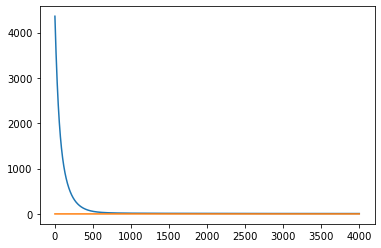

In [62]:
# ys_l = target_spk_one_trial_oneneuron.astype(float)
ys_l = target_spk_one_trial_one_neuron.astype(float)#target_spk_oneneuron.astype(float)
nfields_mask = np.array([1,1,1,1])
key_int = numpy.random.randint(100)
key = jax.random.PRNGKey(key_int)
pars_init = glm.random_init_jax(key,regressors_,nfields_max=len(nfields_mask))
loss_type = 1

smthwin_schedule = [30,0.1]#[30,30,0.1]#
lr_schedule = [0.05,0.01]#[0.05,0.02,0.0001]#
niters_schedule = [4000,4000]#[4000,4000,2000]

pars_curr = pars_init
loss_l_l = []

pars_curr_l = []
for smthwin,lr,niters in zip(smthwin_schedule,lr_schedule, niters_schedule):

    ys_l_filt = gaussian_filter1d(ys_l.astype(float) ,smthwin,mode='constant',cval=0)
    if smthwin >1:
        %time pars_curr,loss_l = glm.train_adam(regressors_,pars_curr,ys_l_filt,reg_pars,nfields_mask,loss_type=loss_type,reg_type=0,lr=lr,niters=niters,mask=None)
    else:
        %time pars_curr,loss_l = glm.train_adam(regressors_,pars_curr,ys_l_filt,reg_pars,nfields_mask,loss_type=0,reg_type=0,lr=lr,niters=niters,mask=None)
    pars_curr_l.append(pars_curr)
    loss = glm.negative_logpdf_no_reg(regressors_,pars_curr,ys_l,nfields_mask,mask=None,loss_type=0,reg_pars=reg_pars,reg_type=0)
#     loss_l.append(loss)
    plt.plot(loss_l)
    loss_l_l.append(loss_l)
pars_learned = pars_curr
# print(loss_l)
print(pars_learned)



In [84]:
reload(glm)
smthwin_schedule = np.array([30,0.1])#[30,30,0.1]#
ys_l_smthed = np.array([gaussian_filter1d(ys_l.astype(float) ,smthwin,mode='constant',cval=0) for smthwin in smthwin_schedule])
lr_schedule = np.array([0.05,0.01])#[0.05,0.02,0.0001]#
niters_schedule = np.array([4000,4000])#[4000,4000,2000]
%time pars_learned= glm.train_adam_schedule(regressors_,pars_init,ys_l_smthed,reg_pars,nfields_mask,reg_type=0,lr_l=lr_schedule, niters_l=niters_schedule,smthwin_l=smthwin_schedule,mask=None)



CPU times: user 6.73 s, sys: 19.8 ms, total: 6.75 s
Wall time: 6.72 s


In [73]:
# reload(glm)
# pars_init_all = 
# ys_l_smthed_all = 
# mask = None
# glm.train_adam_allneurons_same_regpars_schedule(regressors_,pars_init_all,ys_l_smthed_all,reg_pars,nfields_mask,0,lr_schedule,niters_schedule,smthwin_schedule,mask)

<function gm_glm_bayesian.train_adam_schedule(regressors, pars, ys_l_smthed, reg_pars, nfields_mask, reg_type=0, lr_l=[0.1], niters_l=[100], smthwin_l=[30], mask=None)>

In [94]:
import glm_cv as glmc
reload(glmc)

<module 'glm_cv' from '/mnt/home/szheng/projects/util_code/glm_cv.py'>

In [80]:
ys_l_smthed

(2, 10830)

In [95]:
ch=0
regressors_one_trial,target_spk_one_trial = glm.subselect_regressors(regressors, target_spk_allneurons, trial_type=ch)


In [107]:
ys_l_smthed_allneurons = []
for win in smthwin_schedule:
    ys_l_smthed_allneurons.append(gaussian_filter1d(target_spk_one_trial,win,mode='constant',cval=0,axis=0))
ys_l_smthed_allneurons = np.array(ys_l_smthed_allneurons)

In [85]:
mask = glmc.get_train_test_mask_from_space(regressors_,ratio_consec_bins_to_mask=0.2)
nfields_max=4
pars_learned_trans, test_loss = glmc.train_and_test(key,ys_l_smthed,regressors_,nfields_mask,reg_pars_=reg_pars,reg_type=0,mask=mask,loss_type=0,niters_l=niters_schedule,
                    lr_l=lr_schedule,nfields_max=nfields_max,smthwin_l=smthwin_schedule
                   )


In [121]:
%time pars_learned_trans, test_loss = glmc.train_and_test_all_neurons(key,ys_l_smthed_allneurons,regressors_,nfields_mask,reg_pars_=reg_pars,reg_type=0,mask=mask,loss_type=0,niters_l=np.array([1,1]), \
                    lr_l=lr_schedule,nfields_max=nfields_max,smthwin_l=smthwin_schedule)
                   

CPU times: user 7.22 s, sys: 128 ms, total: 7.35 s
Wall time: 7.15 s


In [88]:
pars_learned = pars_learned_trans

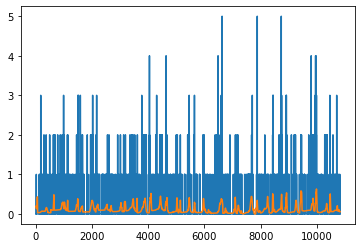

In [89]:
# nfields_mask = reg_pars_l['nfields_mask'][regpars_ind]
yhat=glm.forward(regressors_,pars_learned,nfields_mask,sigma_min=1)
# yhat=glm.forward(regressors_,pars_learned_post,nfields_mask,sigma_min=1)

# plt.plot(target_all_neurons[:,pyr_ind])
# plt.plot(ys_l_filt)
plt.plot(ys_l)
plt.plot(yhat)

In [90]:
pars_learned
pars_learned_selected_masked = mask_fields(pars_learned,nfields_mask)
reload(glm)
regressors_frmap=copy.copy(regressors_)
nbins=222
# fr_['lin_binned_fine'],bins = pd.cut(fr_['lin'],bins=nbins,labels=False,retbins=True)
# occupancy_in_bins=fr_.groupby(['trial','lin_binned_fine']).count().iloc[:,0]
regressors_frmap['xs'] = np.arange(nbins)
nt = pars_learned_selected_masked['delta_ws'].shape[0]
# regressors_frmap['trial_type_by_trial'] = np.zeros(nt).astype(int)
trial_type_by_trial = fr_.groupby(['trial','visitedArm']).mean().index.get_level_values(1)
# regressors_frmap['trial_type_by_trial'] = np.array(trial_type_by_trial,dtype=int)
regressors_frmap['trial_type_by_trial'] = np.zeros(regressors_['ntrials'],dtype=int)
fr_map_hat_oneneuron=glm.gm_func_by_trial(regressors_frmap,pars_learned_selected_masked)
# fr_map_hat_oneneuron=glm.gm_func_by_trial(regressors_frmap,pars_learned_post)

In [35]:
fr_map_hat_oneneuron.shape

(222, 21)

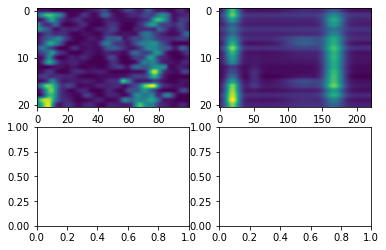

In [91]:
fig,axs=plt.subplots(2,2)
# for tt in [0,1]:
for tt in [0]:
    axs[tt,0].imshow(fr_map_[tt][unit_ind_in_pyr].T,aspect='auto')
    trial_ma = regressors_frmap['trial_type_by_trial']==tt
    axs[tt,1].imshow(fr_map_hat_oneneuron[:,trial_ma].T,aspect='auto')

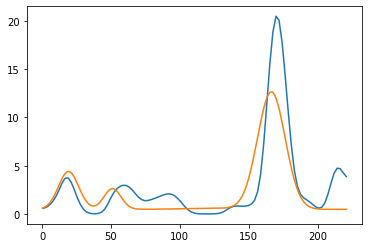

In [92]:
ttt=13
trial_ma = regressors_frmap['trial_type_by_trial']==tt
plt.plot(bin_to_lin,fr_map_[tt][unit_ind_in_pyr].T[ttt])
plt.plot(fr_map_hat_oneneuron[:,trial_ma].T[ttt])

In [173]:
# fr_map_from_fr = fr_.groupby(['visitedArm','trial','lin_binned'])[cell_cols['pyr']].mean()

In [55]:
pars_learned_afterinvtrans['mus']

DeviceArray([[ 19.139904, 126.63898 , 166.35274 , 212.88863 ],
             [ 12.781515,  20.8584  , 115.56924 , 207.45279 ]],            dtype=float32)

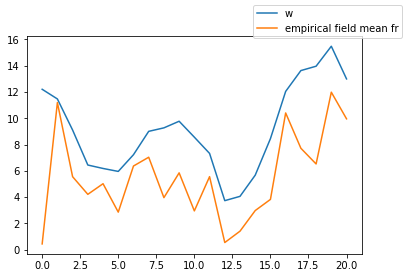

In [144]:
# plt.plot(fr_map_hat_oneneuron[:50].mean(axis=0))
pars_learned_afterinvtrans = glm.pars_invtransform(pars_learned,regressors_)
fig,ax=plt.subplots()
trial_ma = regressors_frmap['trial_type_by_trial']==0
# ax.plot(pars_learned_afterinvtrans['ws'][trial_ma,0],label='w')
ax.plot(pars_learned_afterinvtrans['ws'][trial_ma,0:1].sum(axis=1),label='w')
ax.plot(fr_map_[0][unit_ind_in_pyr][:20].mean(axis=0),label='empirical field mean fr')
fig.legend()


In [337]:
reload(glmc)
reload(glm)

<module 'gm_glm_bayesian' from '/mnt/home/szheng/projects/util_code/gm_glm_bayesian.py'>

# CV

In [41]:
reload(glmc)

<module 'glm_cv' from '/mnt/home/szheng/projects/util_code/glm_cv.py'>

In [ ]:
reload(glm)
smthwin_l = np.array([30,0.1])
target_all_neurons_smthed = glm.smooth_target(target_all_neurons,smthwin_l)

In [81]:

regressors_one_trial_d,target_spk_one_trial_d={},{}
ch=0
pyr_ind = 0
reg_pars_ = gm.get_reg_pars({'g_w':1000.,'g_b':10000.,'g_sigma_thresh':100000.,'sigma_thresh':3,'g_sigma_shrinkage':0.})
cv_kwargs_= {'cv_fold':10}

# reg_pars_tosweep_kwargs_={'g_w':[0.00001,0.0001,0.001,0.01,0.1,100.],'g_b':[0.00001,0.001,0.1,100.],'nfields':[1,2,3,4]}
reg_pars_tosweep_kwargs_={'g_w':[100.],'g_b':[100.,1000000.],'nfields':[3]}
nfields_max = numpy.max(reg_pars_tosweep_kwargs_['nfields'])

fit_kwargs_=dict(niters_l = np.array([1,1]),smthwin_l = smthwin_l,lr_l = np.array([0.05,0.02]),nfields_max=nfields_max)

regressors_one_trial_d[ch], target_spk_one_trial_d[ch]=glm.subselect_regressors(regressors, target_spk_allneurons[:,[0]], trial_type=ch)
target_all_neurons = target_spk_one_trial_d[ch]#target_spk_allneurons #
regressors_ = regressors_one_trial_d[ch]
# regressors_ = regressors
regressors_['ntrials'] = len(numpy.unique(regressors_['trial_inds_int']))
# save_kwargs_ = {'dir':os.path.join(py_data_dir,'glm_deterministic'),'fn':f'cv_trial{ch}_allneuron.p'}
save_kwargs_ = {'dir':os.path.join(py_data_dir,'glm_deterministic'),'fn':f'cv_trial{ch}_pyr{pyr_ind}.p'}
fn_full, cv_kwargs, fit_kwargs, reg_pars_l, reg_pars_name, mask_l, reg_pars_df=glmc.cv_prep(regressors_,reg_pars_tosweep_kwargs_=reg_pars_tosweep_kwargs_,reg_pars_=reg_pars_,fit_kwargs_=fit_kwargs_,cv_kwargs_=cv_kwargs_,save_kwargs_={},nfields_max=nfields_max)
nfields_mask_l = reg_pars_l['nfields_mask']
dosave = True
forcereload = True



In [63]:
reg_pars_l_repeated=tree_map(lambda x:np.tile(x,cv_kwargs['cv_fold']) if len(x.shape)==1 else np.tile(x,(cv_kwargs['cv_fold'],1)),reg_pars_l)
n_regpars = len(reg_pars_l['g_w'])
mask_l_repeated = np.repeat(mask_l,n_regpars,axis=0)



In [68]:



niters_l = np.array([2000,2000])
lr_l = np.array([0.05,0.02])

train_and_test_all_neurons_wrapper = lambda args:glmc.train_and_test_all_neurons(key,target_all_neurons_smthed,regressors_,args[0],reg_pars_=args[1],reg_type = 0,mask=args[2],loss_type=0,niters_l=niters_l,lr_l=lr_l,smthwin_l=smthwin_l,nfields_max=nfields_max)

%time res = lax.map(train_and_test_all_neurons_wrapper,(reg_pars_l_repeated['nfields_mask'],reg_pars_l_repeated,mask_l_repeated))

# pars_learned,test_loss = train_and_test_all_neurons(key,target_all_neurons_smthed,regressors,nfields_mask,reg_pars_={},reg_type = 0,mask=None,loss_type=0,niters_l=[4000],lr_l=[0.05],smthwin_l=[30],nfields_max=5)



CPU times: user 1min 9s, sys: 27.9 ms, total: 1min 9s
Wall time: 1min 9s


In [86]:
!python ../util_code/glm_cv.py 1

submitit executor will schedule jobs on slurm!
2022-08-24 22:55:13.781181: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
all jobs submitted
all jobs submitted


In [103]:
fn=os.path.join(save_kwargs_['dir'],'cv_trial1_allneuron_new.p')
res=pickle.load(open(fn,'rb'))

In [106]:
res['loss']

,S_l1,g_mu,g_sigma,g_w,g_b,sigma_thresh,g_sigma_thresh,nfields,g_order,g_sigma_shrinkage,...,unit_367,unit_368,unit_369,unit_370,unit_371,unit_372,unit_373,unit_374,unit_375,unit_376
0,100000000.0,200.0,1000.0,100.0,100.0,3,100000.0,1,1000.0,0.0,...,0.166795,0.161024,0.035867,0.113848,0.266569,0.217234,0.136937,0.141855,0.162382,0.200609
1,100000000.0,200.0,1000.0,100.0,100.0,3,100000.0,2,1000.0,0.0,...,0.369218,0.559873,0.177468,0.674031,0.551585,0.956548,0.215956,0.539468,0.439992,0.300119


In [97]:
fn_full

'cv_one_neuron.p'

In [96]:
save_kwargs_

{'dir': '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/glm_deterministic',
 'fn': 'cv_trial0_pyr0.p'}

In [99]:
reload(glmc)
res=glmc.cv_all_neurons(target_all_neurons,regressors_,reg_pars_tosweep_kwargs_=reg_pars_tosweep_kwargs_,reg_pars_=reg_pars_,fit_kwargs_=fit_kwargs_,cv_kwargs_=cv_kwargs_,dosave=True,save_kwargs_=save_kwargs_,forcereload=True,key_int=0,col_names=cell_cols['pyr'][:1])




saved at /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/glm_deterministic/cv_trial0_pyr0.p


In [101]:
pickle.load(open('/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/glm_deterministic/cv_trial0_pyr0.p','rb'))

{'loss':            S_l1   g_mu  g_sigma    g_w        g_b  sigma_thresh  \
 0   100000000.0  200.0   1000.0  100.0      100.0             3   
 1   100000000.0  200.0   1000.0  100.0  1000000.0             3   
 2   100000000.0  200.0   1000.0  100.0      100.0             3   
 3   100000000.0  200.0   1000.0  100.0  1000000.0             3   
 4   100000000.0  200.0   1000.0  100.0      100.0             3   
 5   100000000.0  200.0   1000.0  100.0  1000000.0             3   
 6   100000000.0  200.0   1000.0  100.0      100.0             3   
 7   100000000.0  200.0   1000.0  100.0  1000000.0             3   
 8   100000000.0  200.0   1000.0  100.0      100.0             3   
 9   100000000.0  200.0   1000.0  100.0  1000000.0             3   
 10  100000000.0  200.0   1000.0  100.0      100.0             3   
 11  100000000.0  200.0   1000.0  100.0  1000000.0             3   
 12  100000000.0  200.0   1000.0  100.0      100.0             3   
 13  100000000.0  200.0   1000.0  100.0 

In [43]:

reg_pars_df

,S_l1,g_mu,g_sigma,g_w,g_b,sigma_thresh,g_sigma_thresh,nfields,g_order,g_sigma_shrinkage,reg_pars_ind
0,100000000.0,200.0,1000.0,100.0,100.0,3,100000.0,1,1000.0,0.0,0
1,100000000.0,200.0,1000.0,100.0,100.0,3,100000.0,3,1000.0,0.0,1
2,100000000.0,200.0,1000.0,1000000.0,100.0,3,100000.0,1,1000.0,0.0,2
3,100000000.0,200.0,1000.0,1000000.0,100.0,3,100000.0,3,1000.0,0.0,3


In [69]:
reg_pars_df_full = pd.concat([reg_pars_df] * cv_kwargs['cv_fold'],axis=0).reset_index(drop=True)

In [70]:
test_loss_df = pd.DataFrame(res[1])
test_loss_df_full = pd.concat([reg_pars_df_full,test_loss_df],axis=1)

In [71]:
test_loss_df_full.groupby('reg_pars_ind').agg(['mean','sem'])

S_l1        g_mu      g_sigma         g_w       \
                     mean  sem   mean  sem    mean  sem   mean  sem   
reg_pars_ind                                                          
0             100000000.0  0.0  200.0  0.0  1000.0  0.0  100.0  0.0   
1             100000000.0  0.0  200.0  0.0  1000.0  0.0  100.0  0.0   

                    g_b       ... g_sigma_thresh      nfields      g_order  \
                   mean  sem  ...           mean  sem    mean  sem    mean   
reg_pars_ind                  ...                                            
0                 100.0  0.0  ...       100000.0  0.0     3.0  0.0  1000.0   
1             1000000.0  0.0  ...       100000.0  0.0     3.0  0.0  1000.0   

                  g_sigma_shrinkage              0            
              sem              mean  sem      mean       sem  
reg_pars_ind                                                  
0             0.0               0.0  0.0  0.352356  0.019008  
1             0.0               0.0  0.0  0.361304  0.018740  

[2 rows x 22 columns]

In [67]:
test_loss_df_full.groupby('reg_pars_ind').agg(['mean','sem'])

S_l1        g_mu      g_sigma         g_w       \
                     mean  sem   mean  sem    mean  sem   mean  sem   
reg_pars_ind                                                          
0             100000000.0  0.0  200.0  0.0  1000.0  0.0  100.0  0.0   
1             100000000.0  0.0  200.0  0.0  1000.0  0.0  100.0  0.0   

                    g_b       ... g_sigma_thresh      nfields      g_order  \
                   mean  sem  ...           mean  sem    mean  sem    mean   
reg_pars_ind                  ...                                            
0                 100.0  0.0  ...       100000.0  0.0     3.0  0.0  1000.0   
1             1000000.0  0.0  ...       100000.0  0.0     3.0  0.0  1000.0   

                  g_sigma_shrinkage              0            
              sem              mean  sem      mean       sem  
reg_pars_ind                                                  
0             0.0               0.0  0.0  0.350307  0.019224  
1             0.0               0.0  0.0  0.360439  0.018977  

[2 rows x 22 columns]

In [574]:
cell_cols_one = cell_cols['pyr'][pyr_ind:(pyr_ind+1)] 
%time res_one_neuron=glmc.cv_all_neurons(target_all_neurons[:,[pyr_ind]],regressors_,reg_pars_tosweep_kwargs_=reg_pars_tosweep_kwargs_,reg_pars_=reg_pars_,fit_kwargs_=fit_kwargs_,cv_kwargs_=cv_kwargs_,dosave=dosave,save_kwargs_=save_kwargs_,forcereload=forcereload,key_int=0,col_names=cell_cols['pyr'][pyr_ind:(pyr_ind+1)])



CPU times: user 28.8 s, sys: 58.8 ms, total: 28.9 s
Wall time: 28.2 s


In [575]:
res_one_neuron['loss'].groupby('regpars_ind').mean().sort_values(cell_cols_one[0])

,S_l1,g_mu,g_sigma,g_w,g_b,sigma_thresh,g_sigma_thresh,nfields,g_order,g_sigma_shrinkage,unit_31
regpars_ind,,,,,,,,,,,
0,100000000.0,200.0,1000.0,100.0,100.0,3.0,100000.0,1.0,1000.0,0.0,0.425894
2,100000000.0,200.0,1000.0,1000000.0,100.0,3.0,100000.0,1.0,1000.0,0.0,0.502942
1,100000000.0,200.0,1000.0,100.0,100.0,3.0,100000.0,3.0,1000.0,0.0,0.616139
3,100000000.0,200.0,1000.0,1000000.0,100.0,3.0,100000.0,3.0,1000.0,0.0,0.766921


In [576]:
pars_learned_ = res_one_neuron['pars_learned']
ma_ind=0
regpars_ind = 0
pars_learned_selected = glmh.index_into_pytree(pars_learned_[ma_ind],regpars_ind)
pars_learned_selected = glmh.index_into_pytree(pars_learned_selected,0) # select one neuron

In [342]:
reg_pars_selected

{'S_l1': DeviceArray(1.e+08, dtype=float32),
 'g_b': DeviceArray(100., dtype=float32),
 'g_mu': DeviceArray(200., dtype=float32),
 'g_order': DeviceArray(1000., dtype=float32),
 'g_sigma': DeviceArray(1000., dtype=float32),
 'g_sigma_shrinkage': DeviceArray(0., dtype=float32),
 'g_sigma_thresh': DeviceArray(100000., dtype=float32),
 'g_w': DeviceArray(100., dtype=float32),
 'nfields': DeviceArray(1, dtype=int32),
 'nfields_mask': DeviceArray([ True, False, False], dtype=bool),
 'sigma_thresh': DeviceArray(3, dtype=int32)}

In [555]:
# glm.negative_logpdf_no_reg(regressors_,pars_learned_selected,target_all_neurons[:,pyr_ind],reg_pars_l['nfields_mask'][regpars_ind],mask=np.logical_not(res_one_neuron['mask'][ma_ind]),loss_type=0)
reg_pars_selected=glmh.index_into_pytree(reg_pars_l,regpars_ind)
# reg_pars_selected['g_sigma_thresh']=0.
# reg_pars_selected['g_sigma_thresh']=0.
# reg_pars_selected['g_w']=1000000.
# reg_pars_selected['g_b']=10000000000.
glm.negative_logpdf(regressors_,pars_learned_selected,target_all_neurons[:,pyr_ind],reg_pars_l['nfields_mask'][regpars_ind],mask=np.logical_not(res_one_neuron['mask'][ma_ind]),loss_type=0,reg_pars=reg_pars_selected)
                                                                            
                                                                            

                                                                            
                                                                            



DeviceArray(0.44514427, dtype=float32)

In [211]:
glmh.index_into_pytree(reg_pars_l,regpars_ind)

{'S_l1': DeviceArray(1.e+08, dtype=float32),
 'g_b': DeviceArray(100., dtype=float32),
 'g_mu': DeviceArray(200., dtype=float32),
 'g_order': DeviceArray(1000., dtype=float32),
 'g_sigma': DeviceArray(1000., dtype=float32),
 'g_sigma_shrinkage': DeviceArray(0., dtype=float32),
 'g_sigma_thresh': DeviceArray(100000., dtype=float32),
 'g_w': DeviceArray(1.e-04, dtype=float32),
 'nfields': DeviceArray(1, dtype=int32),
 'nfields_mask': DeviceArray([ True, False, False], dtype=bool),
 'sigma_thresh': DeviceArray(3, dtype=int32)}

In [545]:
key = jax.random.PRNGKey(100)
nfields_mask = reg_pars_l['nfields_mask'][regpars_ind]
nfields_max = len(nfields_mask)
pars_learned_post,test_loss_post=glmc.train_and_test(key,target_all_neurons[:,pyr_ind],regressors_,nfields_mask,reg_pars_=glmh.index_into_pytree(reg_pars_l,regpars_ind),reg_type = 0,mask=res_one_neuron['mask'][ma_ind],loss_type=0,niters=8000,lr=0.05,nfields_max=nfields_max)




In [577]:
ma_ind=0
regpars_ind = 3
pars_learned_selected = glmh.index_into_pytree(pars_learned_[ma_ind],regpars_ind)
pars_learned_selected = glmh.index_into_pytree(pars_learned_selected,0) # select one neuron

In [548]:
# pars_learned_selected = pars_learned_post

In [578]:
nfields_mask = reg_pars_l['nfields_mask'][regpars_ind]
yhat=glm.forward(regressors_,pars_learned_selected,nfields_mask,sigma_min=1)
# yhat=glm.forward(regressors_,pars_learned_post,nfields_mask,sigma_min=1)

plt.plot(target_all_neurons[:,pyr_ind])
plt.plot(yhat)

In [606]:
df=pd.DataFrame(numpy.array([yhat,target_all_neurons[:,pyr_ind]]).T,columns=['yhat','y'])

In [607]:
pd.cut(df,bins=)

,yhat,y
0,0.259511,0.0
1,0.257877,0.0
2,0.254630,0.0
3,0.253016,0.0
4,0.249811,0.0
...,...,...
18214,1.226577,0.0
18215,1.227593,2.0
18216,1.233628,0.0
18217,1.238570,0.0


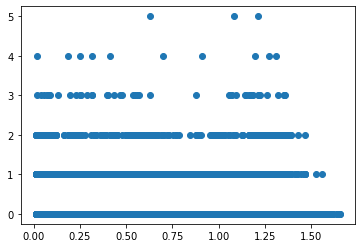

In [603]:
plt.scatter(yhat,target_all_neurons[:,pyr_ind])

In [11]:
pars_learned_selected_masked = mask_fields(pars_learned_selected,reg_pars_l['nfields_mask'][regpars_ind])
reload(glm)
regressors_frmap=copy.copy(regressors_)
# nbins=222
# fr_['lin_binned_fine'],bins = pd.cut(fr_['lin'],bins=nbins,labels=False,retbins=True)
# occupancy_in_bins=fr_.groupby(['trial','lin_binned_fine']).count().iloc[:,0]
regressors_frmap['xs'] = np.arange(nbins)
regressors_frmap['trial_type_by_trial'] = np.array(trial_type_by_trial)
# regressors_frmap['occupancy_in_bins'] = occupancy_in_bins
fr_map_hat_oneneuron=glm.gm_func_by_trial(regressors_frmap,pars_learned_selected_masked)
# fr_map_hat_oneneuron=glm.gm_func_by_trial(regressors_frmap,pars_learned_post)

NameError: name 'pars_learned_selected' is not defined

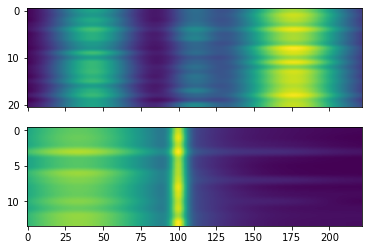

In [581]:
fig,axs=plt.subplots(2,1,sharex=True)
for ii,ch in enumerate((0,1)):
    axs[ii].imshow(fr_map_hat_oneneuron.T[regressors_['trial_type_inds'][ch]],aspect='auto',interpolation=None)

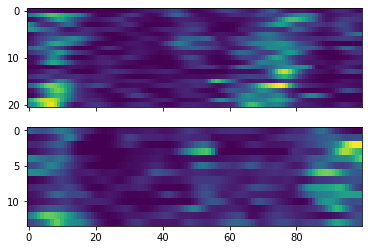

In [582]:
fig,ax=plt.subplots(2,1,sharex=True)
ax[0].imshow(fr_map_[0][unit_ind_in_pyr].T,aspect='auto')
ax[1].imshow(fr_map_[1][unit_ind_in_pyr].T,aspect='auto')
# ax[1].set_xticklabels()

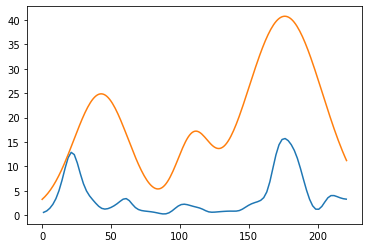

In [572]:
t=2
plt.plot(bin_to_lin,fr_map_[0][unit_ind_in_pyr][:,t])
plt.plot(fr_map_hat_oneneuron[:,t])

In [584]:
fr_['yhat']=yhat

/tmp/ipykernel_49427/1545053925.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fr_['yhat']=yhat


In [585]:
frmap_quick=fr_.groupby(['trial','lin_binned_fine']).mean() / 0.033

<AxesSubplot:xlabel='lin_binned_fine'>

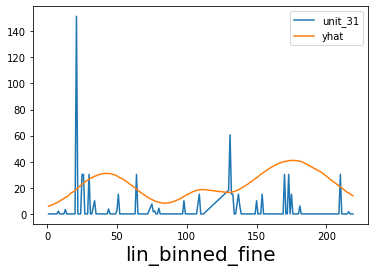

In [602]:
frmap_quick.loc[27,[cell_cols_one[0],'yhat']].plot()

In [590]:
pg=jax.grad(glm.negative_logpdf_no_reg,argnums=1)(regressors_,pars_learned_selected,target_all_neurons[:,pyr_ind],reg_pars_l['nfields_mask'][regpars_ind],mask=np.logical_not(res_one_neuron['mask'][ma_ind]),loss_type=0,reg_pars=reg_pars_selected)

In [520]:
pars_learned_selected['mus']

DeviceArray([[ 42.838467, 109.50514 , 176.1718  ],
             [ 33.32035 ,  99.98702 , 166.65369 ]], dtype=float32)

In [591]:
pg['delta_ws'][regressors_['trial_type_inds'][1]]

DeviceArray([[ 3.47491987e-05,  1.47057544e-09,  3.80617596e-04],
             [-1.13542765e-05,  0.00000000e+00, -1.23988930e-03],
             [ 1.03635582e-04,  7.59747854e-05,  2.90524476e-04],
             [ 4.65867546e-04,  1.18546695e-05,  4.43792442e-06],
             [ 7.91549508e-04,  7.68874670e-05,  5.79889866e-06],
             [ 2.07565346e-04,  4.67342121e-04,  2.77632216e-06],
             [ 1.63787045e-04,  1.05794104e-04,  1.84491967e-06],
             [ 7.12367012e-07,  0.00000000e+00, -1.67053178e-04],
             [ 5.37198910e-04,  7.09521441e-21,  3.20603055e-09],
             [-9.58288638e-06,  0.00000000e+00, -3.51459341e-04],
             [ 6.63304119e-04,  1.33282962e-09,  9.05643674e-07],
             [ 8.51261866e-05,  1.49278294e-05,  1.87733131e-05],
             [ 5.62712608e-04,  2.44140319e-04,  3.43326747e-06],
             [ 2.92633602e-04,  9.30926146e-22,  8.61940852e-10]],            dtype=float32)

In [592]:
pg['logws_bar']

DeviceArray([[ 0.00365215,  0.00472539,  0.0030231 ],
             [ 0.0038879 ,  0.00099692, -0.00104929]], dtype=float32)

In [490]:
pars_learned_selected['logsigmas']

DeviceArray([[19.799631 , 12.141735 , 27.213287 ],
             [47.365517 ,  4.1449165, 27.181768 ]], dtype=float32)